<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON4_RapidAPI_YFinanceJSON_Read_Hourly_Data_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [227]:
import requests

url = "https://yahoo-finance127.p.rapidapi.com/historic/ENKAI.IS/1h/6mo"

headers = {
	"X-RapidAPI-Key": "c4100a6817msh6100fdd804b1ae8p1defa4jsn72757c98b3c0",
	"X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
}

response = requests.get(url, headers=headers)

print(response.json())

{'meta': {'currency': 'TRY', 'symbol': 'ENKAI.IS', 'exchangeName': 'IST', 'instrumentType': 'EQUITY', 'firstTradeDate': 1027924200, 'regularMarketTime': 1692371369, 'gmtoffset': 10800, 'timezone': 'TRT', 'exchangeTimezoneName': 'Europe/Istanbul', 'regularMarketPrice': 32.2, 'chartPreviousClose': 26.92, 'previousClose': 33.78, 'scale': 3, 'priceHint': 2, 'currentTradingPeriod': {'pre': {'timezone': 'TRT', 'start': 1692340200, 'end': 1692340200, 'gmtoffset': 10800}, 'regular': {'timezone': 'TRT', 'start': 1692340200, 'end': 1692370800, 'gmtoffset': 10800}, 'post': {'timezone': 'TRT', 'start': 1692370800, 'end': 1692370800, 'gmtoffset': 10800}}, 'tradingPeriods': [[{'timezone': 'TRT', 'start': 1676874600, 'end': 1676905200, 'gmtoffset': 10800}], [{'timezone': 'TRT', 'start': 1676961000, 'end': 1676991600, 'gmtoffset': 10800}], [{'timezone': 'TRT', 'start': 1677047400, 'end': 1677078000, 'gmtoffset': 10800}], [{'timezone': 'TRT', 'start': 1677133800, 'end': 1677164400, 'gmtoffset': 10800}]

In [228]:
if response.status_code == 200:
    data = response.json()

    # Extract the "close" data
    close_data = data['indicators']['quote'][0]['close']

    # # Create a DataFrame from the "close" data
    # df = pd.DataFrame({'Close': close_data})

    # print(df)

In [229]:
import pandas as pd
timestamps = data["timestamp"]


# Convert timestamps to datetime
timestamps = [pd.to_datetime(ts, unit="s") for ts in timestamps]
timestamps = [ts + pd.Timedelta(hours=3) for ts in timestamps]

# Create a DataFrame
#df = pd.DataFrame({"Date-Time": timestamps, "Close": close_data})
df = pd.DataFrame({"Close": close_data}, index=timestamps)

df[df.index >"2023-08-18 00:00:00"]

,Close
2023-08-18 09:30:00,34.080002
2023-08-18 10:30:00,33.880001
2023-08-18 11:30:00,33.880001
2023-08-18 12:30:00,34.119999
2023-08-18 13:30:00,33.840000
2023-08-18 14:30:00,33.500000
2023-08-18 15:30:00,33.160000
2023-08-18 16:30:00,32.259998
2023-08-18 17:30:00,32.299999
2023-08-18 18:00:00,32.200001


In [230]:
# Create an empty list to store the split DataFrames
split_dataframes = []

# Define the start and end times
start_time = pd.to_datetime("09:30:00").time()
end_time = pd.to_datetime("18:00:00").time()

# Iterate through the DataFrame and split it
for date in df.index.to_series().dt.date.unique():
    daily_data = df[df.index.to_series().dt.date == date]  # Filter data for the current date

    # Filter data for the specified time range
    daily_data = daily_data[(daily_data.index.time >= start_time) & (daily_data.index.time <= end_time)]

    if not daily_data.empty:
        split_dataframes.append(daily_data)

# Print the split DataFrames
for i, split_df in enumerate(split_dataframes):
    print(f"DataFrame {i + 1}:\n{split_df}\n")


DataFrame 1:
                         Close
2023-02-20 09:30:00  26.500000
2023-02-20 10:30:00  26.420000
2023-02-20 11:30:00  27.219999
2023-02-20 12:30:00  27.260000
2023-02-20 13:30:00  26.980000
2023-02-20 14:30:00  26.799999
2023-02-20 15:30:00  26.799999
2023-02-20 16:30:00  27.000000
2023-02-20 17:30:00        NaN

DataFrame 2:
                         Close
2023-02-21 09:30:00  27.959999
2023-02-21 10:30:00  28.760000
2023-02-21 11:30:00  28.700001
2023-02-21 12:30:00  29.120001
2023-02-21 13:30:00  29.160000
2023-02-21 14:30:00  29.540001
2023-02-21 15:30:00  29.500000
2023-02-21 16:30:00  28.860001
2023-02-21 17:30:00        NaN

DataFrame 3:
                         Close
2023-02-22 09:30:00  28.620001
2023-02-22 10:30:00  29.020000
2023-02-22 11:30:00  28.980000
2023-02-22 12:30:00  28.959999
2023-02-22 13:30:00  28.980000
2023-02-22 14:30:00  30.020000
2023-02-22 15:30:00  29.780001
2023-02-22 16:30:00  29.780001
2023-02-22 17:30:00        NaN

DataFrame 4:
               

In [231]:
import numpy as np

# Create empty lists to store peak and lowest price information
peak_hours = []
lowest_hours = []
peak_prices = []
lowest_prices = []

# Iterate through the split DataFrames
for split_df in split_dataframes:
    # Find the timestamp with the maximum price
    max_price_timestamp = split_df["Close"].idxmax()
    max_price = split_df["Close"].max()

    # Find the timestamp with the lowest price
    min_price_timestamp = split_df["Close"].idxmin()
    min_price = split_df["Close"].min()

    # Append the information to the respective lists
    peak_hours.append(max_price_timestamp)
    lowest_hours.append(min_price_timestamp)
    peak_prices.append(max_price)
    lowest_prices.append(min_price)

# Find the overall peak and lowest prices and their corresponding hours
overall_peak_index = np.argmax(peak_prices)
overall_lowest_index = np.argmin(lowest_prices)

overall_peak_hour = peak_hours[overall_peak_index]
overall_lowest_hour = lowest_hours[overall_lowest_index]
overall_peak_price = peak_prices[overall_peak_index]
overall_lowest_price = lowest_prices[overall_lowest_index]

print(f"Overall Peak Price: {overall_peak_price} at {overall_peak_hour}")
print(f"Overall Lowest Price: {overall_lowest_price} at {overall_lowest_hour}")


Overall Peak Price: 35.15999984741211 at 2023-08-01 10:30:00
Overall Lowest Price: 22.979999542236328 at 2023-05-15 09:30:00


In [232]:
# Create an empty list to store results
results = []

# Iterate through the split DataFrames
for i, split_df in enumerate(split_dataframes):
    # Find the timestamp with the highest and lowest prices
    peak_timestamp = split_df['Close'].idxmax()
    lowest_timestamp = split_df['Close'].idxmin()

    # Extract the corresponding prices
    peak_price = split_df['Close'].loc[peak_timestamp]
    lowest_price = split_df['Close'].loc[lowest_timestamp]

    # Append the results for this piece of data to the list
    results.append({
        'DataFrame': i + 1,
        'Peak Hour': peak_timestamp,
        'Peak Price': peak_price,
        'Lowest Hour': lowest_timestamp,
        'Lowest Price': lowest_price
    })

# Convert the results list to a DataFrame for better presentation
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


     DataFrame           Peak Hour  Peak Price         Lowest Hour  \
0            1 2023-02-20 12:30:00   27.260000 2023-02-20 10:30:00   
1            2 2023-02-21 14:30:00   29.540001 2023-02-21 09:30:00   
2            3 2023-02-22 14:30:00   30.020000 2023-02-22 09:30:00   
3            4 2023-02-23 16:30:00   31.400000 2023-02-23 09:30:00   
4            5 2023-02-24 13:30:00   30.959999 2023-02-24 16:30:00   
..         ...                 ...         ...                 ...   
119        120 2023-08-14 10:30:00   35.139999 2023-08-14 15:30:00   
120        121 2023-08-15 14:30:00   34.439999 2023-08-15 16:30:00   
121        122 2023-08-16 16:30:00   34.740002 2023-08-16 09:30:00   
122        123 2023-08-17 11:30:00   34.119999 2023-08-17 15:30:00   
123        124 2023-08-18 12:30:00   34.119999 2023-08-18 18:00:00   

     Lowest Price  
0       26.420000  
1       27.959999  
2       28.620001  
3       30.120001  
4       30.680000  
..            ...  
119     34.000000  

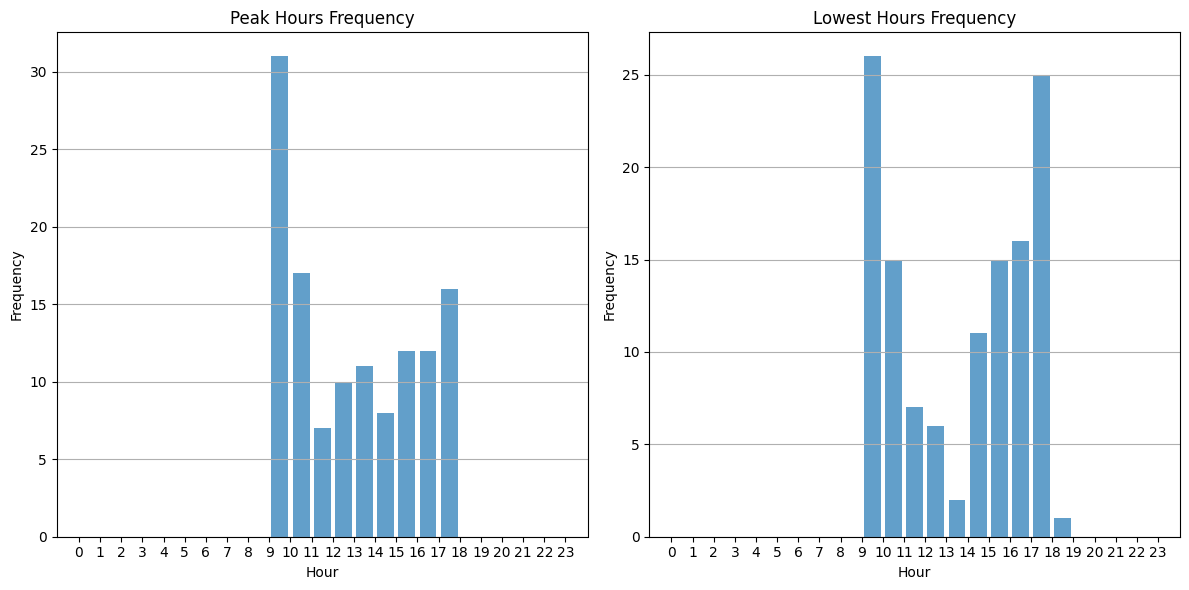

In [233]:
import matplotlib.pyplot as plt

# Create histograms for peak hours and lowest hours
plt.figure(figsize=(12, 6))

# Histogram for peak hours
plt.subplot(1, 2, 1)
plt.hist(results_df['Peak Hour'].dt.hour, bins=range(0, 24), rwidth=0.8, alpha=0.7)
plt.title('Peak Hours Frequency')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Histogram for lowest hours
plt.subplot(1, 2, 2)
plt.hist(results_df['Lowest Hour'].dt.hour,bins=range(0, 24), rwidth=0.8, alpha=0.7)
plt.title('Lowest Hours Frequency')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Adjust spacing between subplots
plt.tight_layout()

# Show the histograms
plt.show()


In [234]:
# ///////////////////////////////////////////////////////////
# FUNCTIONS FOR ALPHA VANTAGE
# ///////////////////////////////////////////////////////////
TIME_SERIES_INTRADAY = 'TIME_SERIES_INTRADAY'
TIME_SERIES_INTRADAY_EXTENDED = 'TIME_SERIES_INTRADAY_EXTENDED'
TIME_SERIES_DAILY = 'TIME_SERIES_DAILY'
TIME_SERIES_DAILY_ADJUSTED = 'TIME_SERIES_DAILY_ADJUSTED'
TIME_SERIES_WEEKLY = 'TIME_SERIES_WEEKLY'
TIME_SERIES_WEEKLY_ADJUSTED = 'TIME_SERIES_WEEKLY_ADJUSTED'
TIME_SERIES_MONTHLY = 'TIME_SERIES_MONTHLY'
TIME_SERIES_MONTHLY_ADJUSTED = 'TIME_SERIES_MONTHLY_ADJUSTED'

# ///////////////////////////////////////////////////////////
# TIME SERIES FOR STOCK DATA
# ///////////////////////////////////////////////////////////
ONEMIN = 'Time Series (1min)'
FIVEMIN = 'Time Series (5min)'
FIVETEENMIN = 'Time Series (15min)'
THIRTYMIN = 'Time Series (30min)'
HOUR = 'Time Series (60min)'
FIVEMIN = 'Time Series (5min)'
DAILY = 'Time Series (Daily)'
WEEKLY = 'Weekly Time Series'
WEEKLY_ADJ = 'Weekly Adjusted Time Series'
MONTLY = 'Monthly Time Series'
MONTLY_ADJ = 'Monthly Adjusted Time Series'

# /////////////////////////////////////////////////////////
# query timeseries stock data of selected type ////////////
# /////////////////////////////////////////////////////////
def query_timeseries_data(func, symbol, outputsize='full', datatype='json', apikey='AN5SOF59K41U0YQ3'):
    data = {
        "function": func, # Here you can put any of the 'funcs' above
        "symbol": symbol,
        "outputsize": outputsize, # (full) and (compact) are accepted
        "datatype": datatype,
        "apikey": apikey
    }
    return requests.get("https://www.alphavantage.co/query", data).json()

# /////////////////////////////////////////////////////////
# convert timeseries stock data of selected type to json //
# /////////////////////////////////////////////////////////
def get_timeseries_dataframe(json, type):
    df = pd.DataFrame.from_dict(json[type], orient= 'index')
    df.index =  pd.to_datetime(df.index, format='%Y-%m-%d')

    df = df.rename(columns={ '1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', '5. volume': 'Volume'})
    df = df.astype({'Open': 'float64', 'High': 'float64', 'Low': 'float64','Close': 'float64','Volume': 'float64',})
    df = df[[ 'Open', 'High', 'Low', 'Close', 'Volume']]
    return df

# Now all you have to do is actually call the funcs
response_json = query_timeseries_data(TIME_SERIES_DAILY, 'MSFT')
stockprice_dataframe = get_timeseries_dataframe(response_json, DAILY)


In [235]:
def PlotHistogramOf(ticker):
    import requests
    import pandas as pd


    url = f"https://yahoo-finance127.p.rapidapi.com/historic/{ticker}/1h/6mo"

    headers = {
      "X-RapidAPI-Key": "c4100a6817msh6100fdd804b1ae8p1defa4jsn72757c98b3c0",
      "X-RapidAPI-Host": "yahoo-finance127.p.rapidapi.com"
    }

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
      data = response.json()
      # Extract the "close" data
      close_data = data['indicators']['quote'][0]['close']

    timestamps = data["timestamp"]

    # Convert timestamps to datetime
    timestamps = [pd.to_datetime(ts, unit="s") for ts in timestamps]
    timestamps = [ts + pd.Timedelta(hours=3) for ts in timestamps]

    # Create a DataFrame
    #df = pd.DataFrame({"Date-Time": timestamps, "Close": close_data})
    df = pd.DataFrame({"Close": close_data}, index=timestamps)

    # df[df.index >"2023-08-18 00:00:00"]
    # Create an empty list to store the split DataFrames
    split_dataframes = []

    # Define the start and end times
    start_time = pd.to_datetime("09:30:00").time()
    end_time = pd.to_datetime("18:00:00").time()

    # Iterate through the DataFrame and split it
    for date in df.index.to_series().dt.date.unique():
        daily_data = df[df.index.to_series().dt.date == date]  # Filter data for the current date

        # Filter data for the specified time range
        daily_data = daily_data[(daily_data.index.time >= start_time) & (daily_data.index.time <= end_time)]

        if not daily_data.empty:
            split_dataframes.append(daily_data)

    # Print the split DataFrames
    # for i, split_df in enumerate(split_dataframes):
    #     print(f"DataFrame {i + 1}:\n{split_df}\n")

    import numpy as np

    # Create empty lists to store peak and lowest price information
    peak_hours = []
    lowest_hours = []
    peak_prices = []
    lowest_prices = []

    # Iterate through the split DataFrames
    for split_df in split_dataframes:
        # Find the timestamp with the maximum price
        max_price_timestamp = split_df["Close"].idxmax()
        max_price = split_df["Close"].max()

        # Find the timestamp with the lowest price
        min_price_timestamp = split_df["Close"].idxmin()
        min_price = split_df["Close"].min()

        # Append the information to the respective lists
        peak_hours.append(max_price_timestamp)
        lowest_hours.append(min_price_timestamp)
        peak_prices.append(max_price)
        lowest_prices.append(min_price)

    # Find the overall peak and lowest prices and their corresponding hours
    overall_peak_index = np.argmax(peak_prices)
    overall_lowest_index = np.argmin(lowest_prices)

    overall_peak_hour = peak_hours[overall_peak_index]
    overall_lowest_hour = lowest_hours[overall_lowest_index]
    overall_peak_price = peak_prices[overall_peak_index]
    overall_lowest_price = lowest_prices[overall_lowest_index]

    #print(f"Overall Peak Price: {overall_peak_price} at {overall_peak_hour}")
    #print(f"Overall Lowest Price: {overall_lowest_price} at {overall_lowest_hour}")
    # Create an empty list to store results
    results = []

    # Iterate through the split DataFrames
    for i, split_df in enumerate(split_dataframes):
        # Find the timestamp with the highest and lowest prices
        peak_timestamp = split_df['Close'].idxmax()
        lowest_timestamp = split_df['Close'].idxmin()

        # Extract the corresponding prices
        peak_price = split_df['Close'].loc[peak_timestamp]
        lowest_price = split_df['Close'].loc[lowest_timestamp]

        # Append the results for this piece of data to the list
        results.append({
            'DataFrame': i + 1,
            'Peak Hour': peak_timestamp,
            'Peak Price': peak_price,
            'Lowest Hour': lowest_timestamp,
            'Lowest Price': lowest_price
        })

    # Convert the results list to a DataFrame for better presentation
    results_df = pd.DataFrame(results)

    # Print the results
    #print(results_df)

    import matplotlib.pyplot as plt

    # Create histograms for peak hours and lowest hours
    plt.figure(figsize=(12, 6))

    # Histogram for peak hours
    plt.subplot(1, 2, 1)
    plt.hist(results_df['Peak Hour'].dt.hour, bins=range(0, 24), rwidth=0.8, alpha=0.7)
    plt.title('Peak Hours Frequency')
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')

    # Histogram for lowest hours
    plt.subplot(1, 2, 2)
    plt.hist(results_df['Lowest Hour'].dt.hour,bins=range(0, 24), rwidth=0.8, alpha=0.7)
    plt.title('Lowest Hours Frequency')
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the histograms
    plt.show()



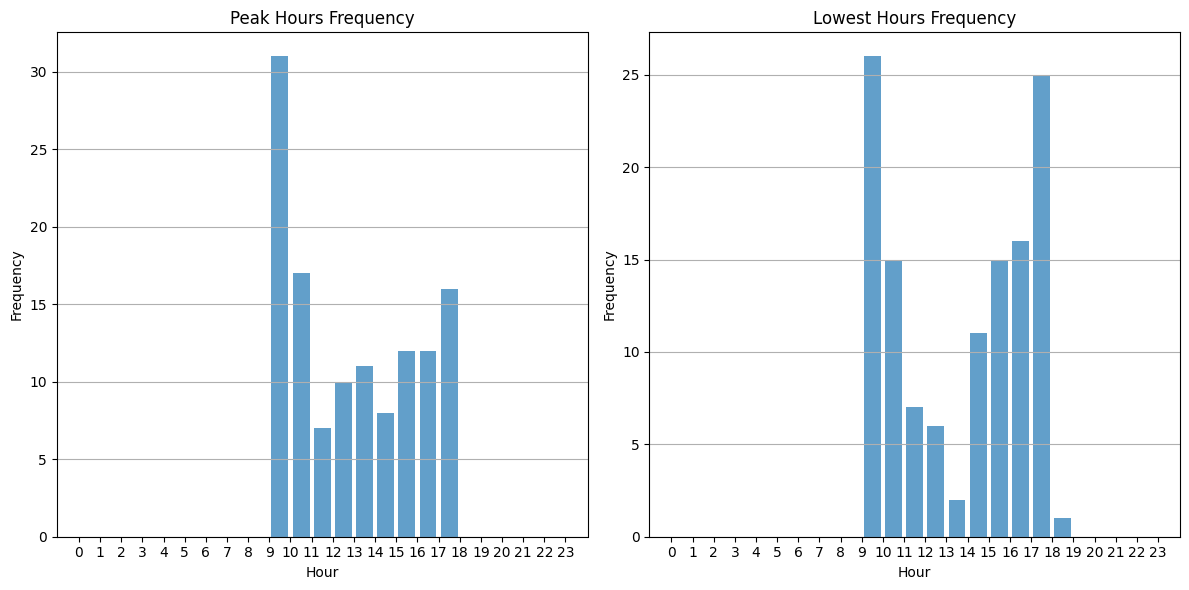

In [236]:
PlotHistogramOf("ENKAI.IS")